In [3]:
# Loading necessary libraries
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

project_root = Path().resolve().parent
sys.path.append(str(project_root))
from dpred.config import settings

In [4]:
# Loading the dataset
df = pd.read_csv(settings.dataset_path)

In [5]:
# Checking first 5 rows of the dataset
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# Checking last 5 rows of the dataset
df.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


### Dataset Descriptions
1. **Pregnancies**  
   - Number of pregnancies a patient has had.  
2. **Glucose**  
   - Plasma glucose concentration.  
3. **BloodPressure**  
   - Diastolic blood pressure (mm Hg).  
4. **SkinThickness**  
   - Triceps skinfold thickness (mm).  
5. **Insulin**  
   - 2-hour serum insulin (mu U/ml).  
6. **BMI**  
   - Body mass index (weight in kg/(height in m)^2).  
7. **DiabetesPedigreeFunction**  
   - Likelihood of diabetes based on family history.  
8. **Age**  
   - Age of the individual (years).  
9. **Outcome**  
   - Diabetes diagnosis:  
     - **0:** Non-diabetic.  
     - **1:** Diabetic.  

In [7]:
df.shape

(768, 9)

## Exploratory Data Analysis

**Getting Detailed Info Regarding Dataset Fields**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


**Checking For Null & Duplicate Values**

In [9]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [10]:
df.duplicated().sum()

np.int64(0)

**Getting Statistical Summary Of Numerical Columns Of Dataset**

In [11]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


**Observation**
- 34.89% of the individuals are diabetic while 64.11% of individuals are non-diabetic.
- Columns like `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI` have minimum value of `0` which is unrealistic.

**Exploring Target Variable (Outcome)**

In [12]:
df.loc[:, 'Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

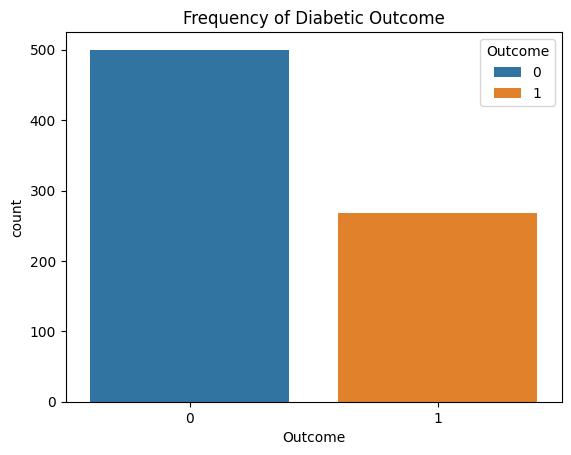

In [13]:
sns.countplot(data=df, x='Outcome', hue='Outcome')
plt.title('Frequency of Diabetic Outcome')
plt.show()

**Getting Insight On The Correlation Between Features**

In [14]:
corr_matrix = df.corr()
print(corr_matrix)

                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.129459       0.141282      -0.081672   
Glucose                      0.129459  1.000000       0.152590       0.057328   
BloodPressure                0.141282  0.152590       1.000000       0.207371   
SkinThickness               -0.081672  0.057328       0.207371       1.000000   
Insulin                     -0.073535  0.331357       0.088933       0.436783   
BMI                          0.017683  0.221071       0.281805       0.392573   
DiabetesPedigreeFunction    -0.033523  0.137337       0.041265       0.183928   
Age                          0.544341  0.263514       0.239528      -0.113970   
Outcome                      0.221898  0.466581       0.065068       0.074752   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.073535  0.017683                 -0.033523   
Glucose                   0.331357  0.221

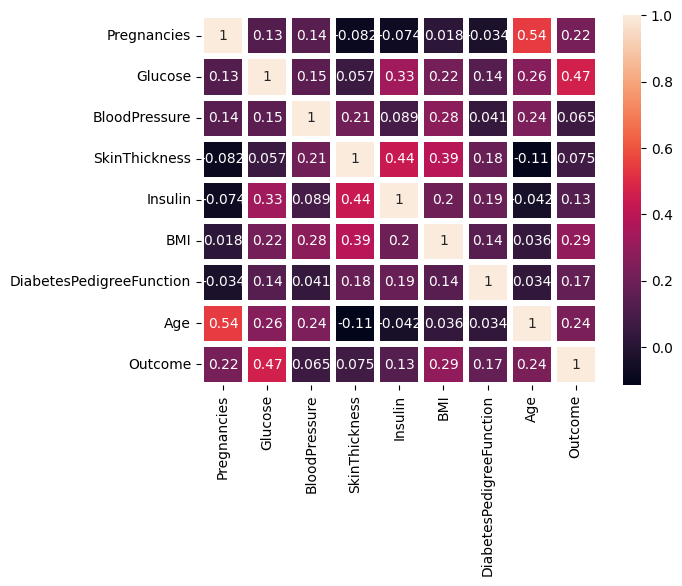

In [15]:
sns.heatmap(corr_matrix, annot=True, linewidth=4)
plt.show()

**Correlation with target variable**

Pregnancies                 0.221898
Glucose                     0.466581
BloodPressure               0.065068
SkinThickness               0.074752
Insulin                     0.130548
BMI                         0.292695
DiabetesPedigreeFunction    0.173844
Age                         0.238356
Name: Outcome, dtype: float64


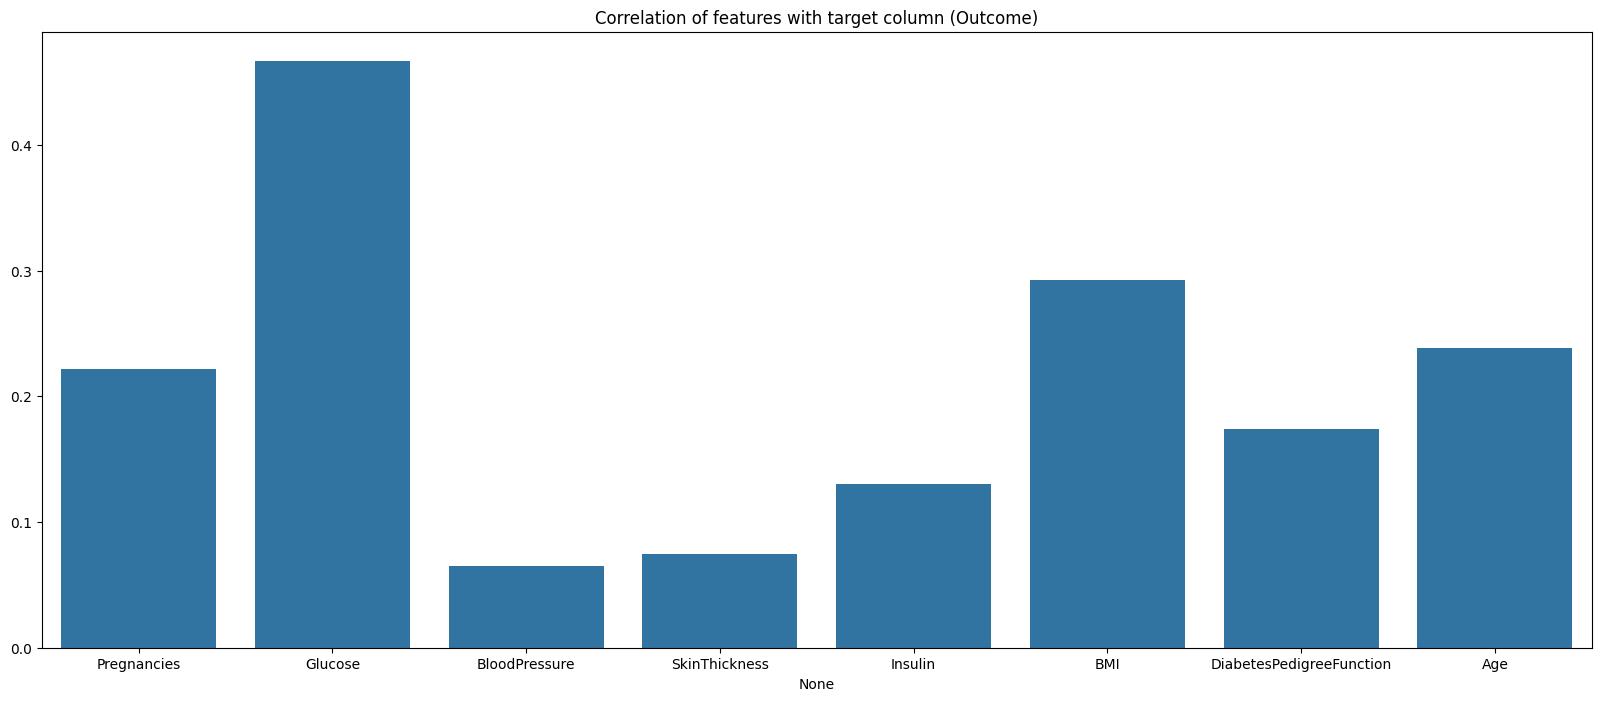

In [16]:
corr_with_target = (df.corr()['Outcome']).drop('Outcome')
print(corr_with_target)
plt.figure(figsize=(20, 8))
sns.barplot(x=corr_with_target.index, y=corr_with_target.values)
plt.title('Correlation of features with target column (Outcome)')
plt.show()

**Understandings**
- `Glucose` is by far the most strongly correlated feature with the target, suggesting it plays a significant role in diabetic condition.
- `BMI` & `Age` also have moderate positive correlation with target, making them important features for prediction.
- `Pregnancies` & `DiabetesPedigreeFunction` are weakly correlate but still suggest some association with diabetes.
- `BloodPressure`, `SkinThickness` & `Insulin` show very less correlation suggesting they may not be useful for prediction.

**Looking at distribution of features**

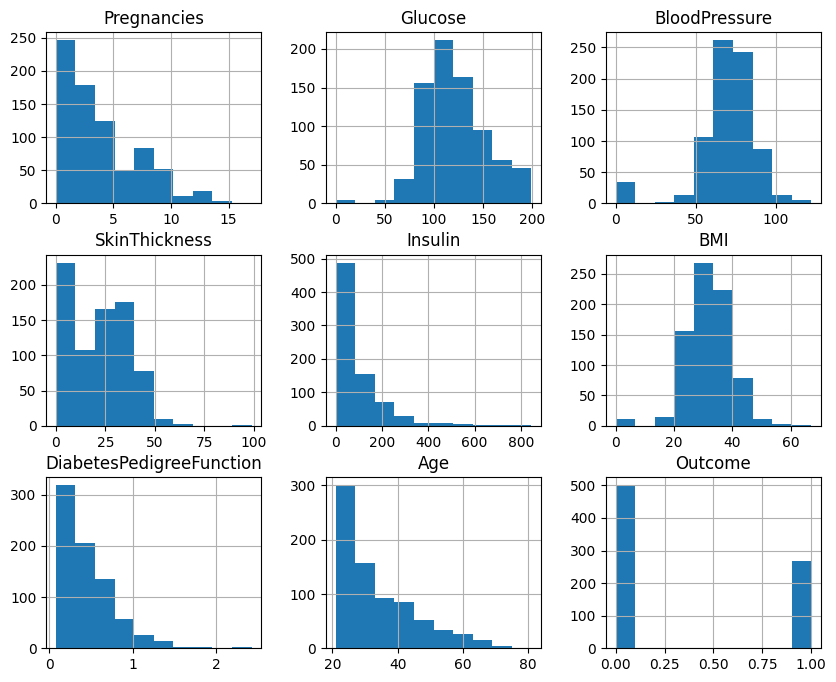

In [17]:
df.hist(figsize=(10, 8))
plt.show()

In [18]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Data Cleaning
We saw some of the unrealistic values like `0` on `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin` & `BMI`
I think KNN Imputer will be a good choice here because we could see some correlation with each other of these various feature columns

**Imputation with KNN Imputer**

In [19]:
# Checking for number of zeroes
(df == 0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [20]:
impute_target_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[impute_target_columns] = df[impute_target_columns].replace(0, np.nan)
knn_imputer = KNNImputer(n_neighbors=5)
df[impute_target_columns] = knn_imputer.fit_transform(df[impute_target_columns])

In [21]:
(df == 0).sum()

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

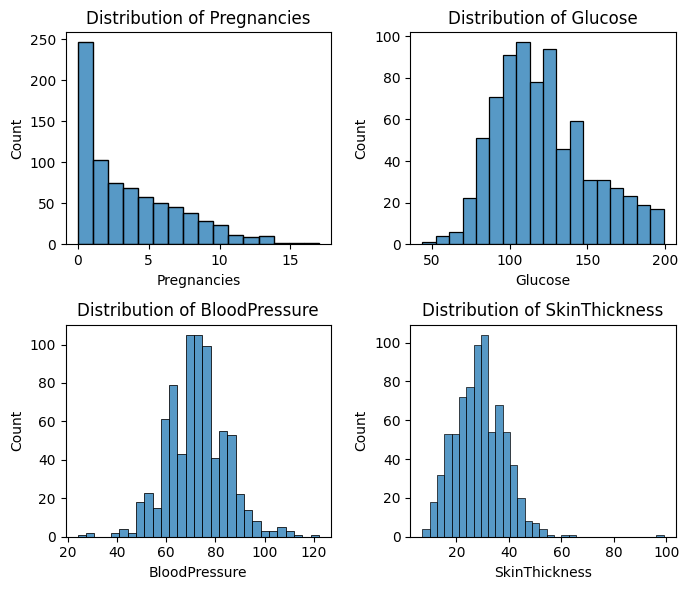

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(7, 6))

sns.histplot(df, x='Pregnancies', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Pregnancies')

sns.histplot(df, x='Glucose', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Glucose')

sns.histplot(df, x='BloodPressure', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of BloodPressure')

sns.histplot(df, x='SkinThickness', ax=axes[1, 1])
axes[1, 1].set_title('Distribution of SkinThickness')

plt.tight_layout()
plt.show()

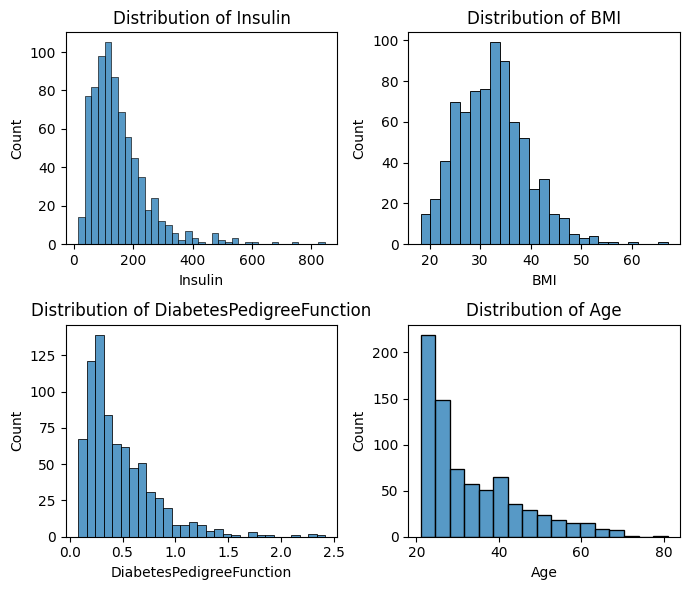

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(7, 6))

sns.histplot(df, x='Insulin', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Insulin')

sns.histplot(df, x='BMI', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of BMI')

sns.histplot(df, x='DiabetesPedigreeFunction', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of DiabetesPedigreeFunction')

sns.histplot(df, x='Age', ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Age')

plt.tight_layout()
plt.show()

In [24]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

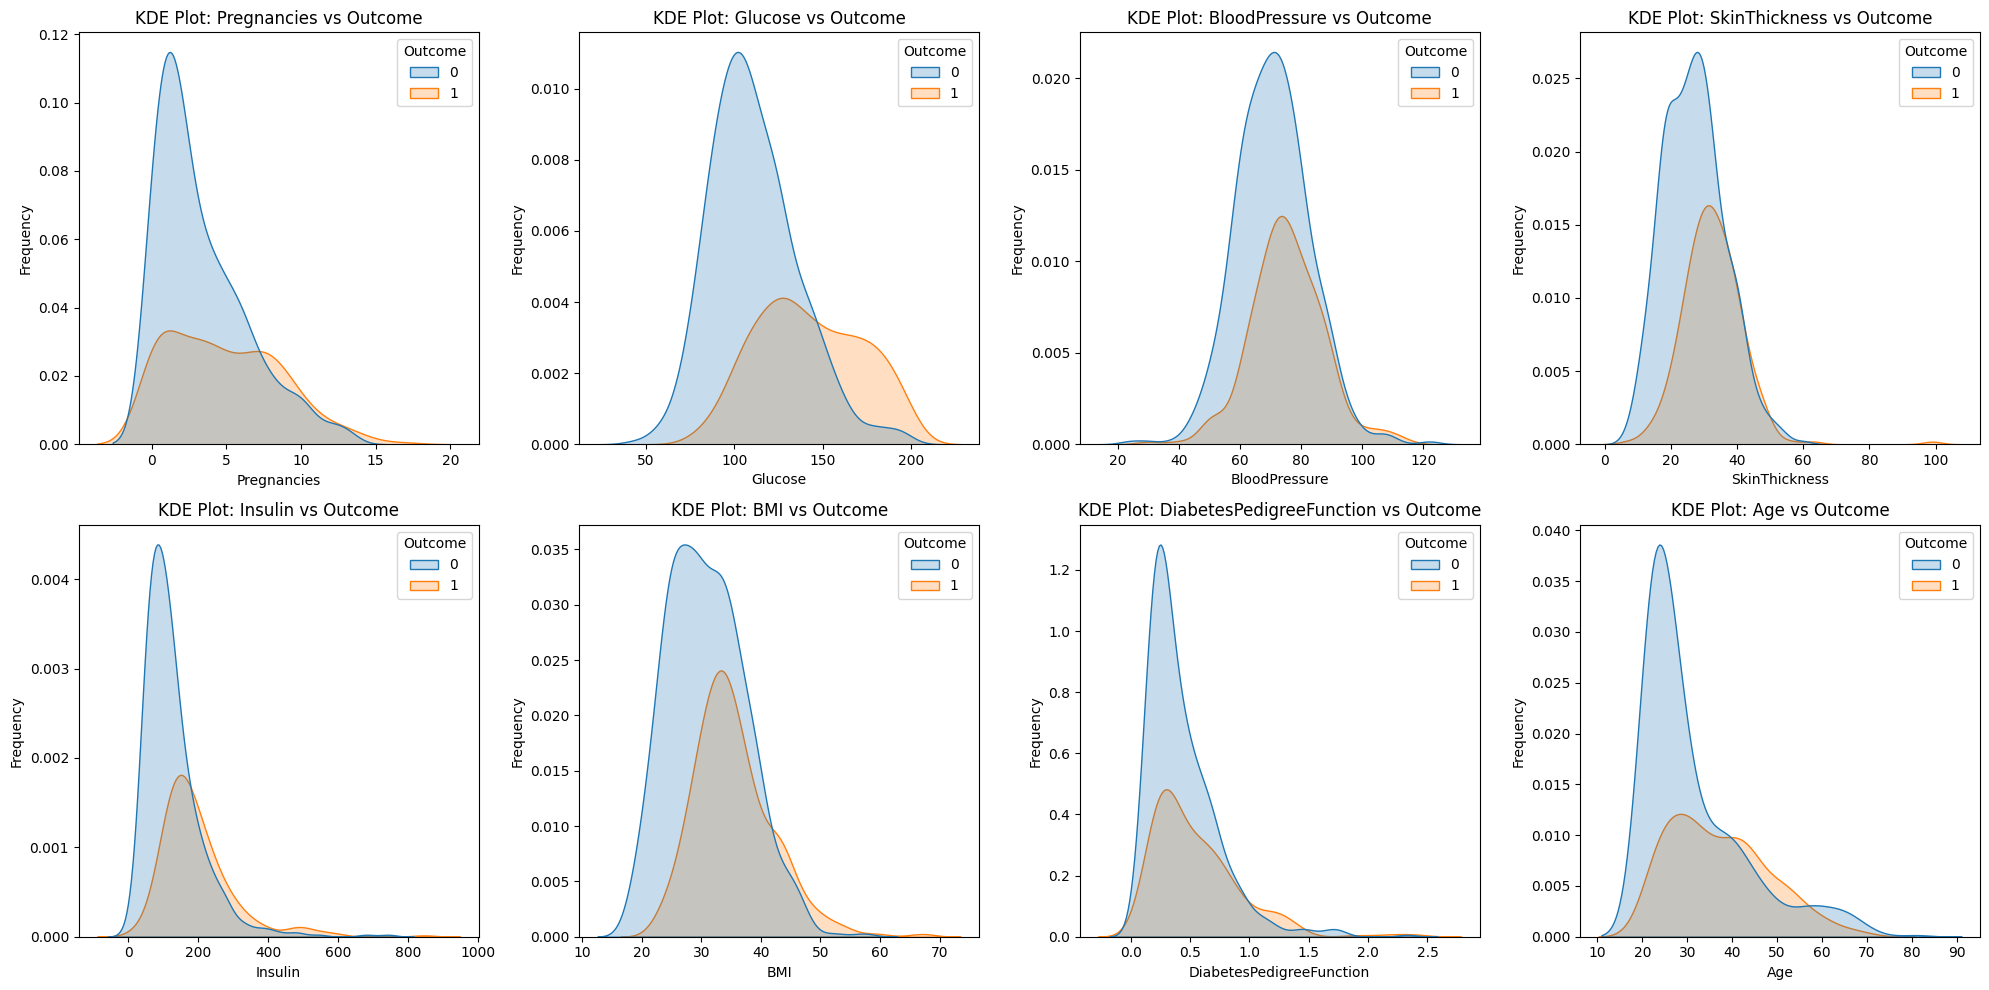

In [25]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
for i, feature in enumerate(features):
    row = i // 4
    col = i % 4
    sns.kdeplot(data=df, x=feature, hue='Outcome', fill=True, ax=axes[row, col])
    axes[row, col].set_title(f'KDE Plot: {feature} vs Outcome')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

## Model Training

In [26]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [27]:
X = df[['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
y = df['Outcome']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
scaler = StandardScaler()
X_trainScaled = scaler.fit_transform(X_train)
X_testScaled = scaler.fit_transform(X_test)

In [30]:
classifiers = {
    "Logistic Regression (Linear)": LogisticRegression()
}

In [31]:
results = {}

In [32]:
for name, model in classifiers.items():
    model.fit(X_trainScaled, y_train)
    cv_scores = cross_val_score(model, X_trainScaled, y_train, cv=5)
    mean_cv_score = cv_scores.mean()
    y_pred = model.predict(X_testScaled)

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_testScaled)[:, 1])
    classification_rep = classification_report(y_test, y_pred)

    results[name] = {
    'Accuracy': accuracy,
    'AUC': auc,
    'Mean CV Score': mean_cv_score,
    'Classification Report': classification_rep
}

In [33]:
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"AUC: {metrics['AUC']:.4f}")
    print(f"Mean CV Score: {metrics['Mean CV Score']:.4f}")
    print(f"Classification Report:\n{metrics['Classification Report']}")
    print("-" * 50)

Model: Logistic Regression (Linear)
Accuracy: 0.7857
AUC: 0.8309
Mean CV Score: 0.7753
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        99
           1       0.74      0.62      0.67        55

    accuracy                           0.79       154
   macro avg       0.77      0.75      0.76       154
weighted avg       0.78      0.79      0.78       154

--------------------------------------------------


## Exporting the trained model

In [34]:
import joblib
from dpred.config import settings

joblib.dump(model, settings.model_path)
print(f"Model saved to: {settings.model_path}")


Model saved to: /home/sudeep/Fusemachines/diabetes-prediction-ml/models/diabetes_model.pkl
